In [1]:
# init
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

import sys
sys.path.append("/kaggle/input/functions/")
from FileObject import print_file_info  

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        file_path=os.path.join(dirname, filename)
        print_file_info(file_path)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


文件详细信息：
文件名称:
  ▸ FileObject.py
--------------------------------------------------
绝对路径:
  ▸ /kaggle/input/functions/FileObject.py
--------------------------------------------------
真实路径:
  ▸ N/A
--------------------------------------------------
文件类型:
  ▸ 普通文件
--------------------------------------------------
文件大小:
  ▸ 3399 bytes
--------------------------------------------------
占用块数:
  ▸ 8
--------------------------------------------------
IO块大小:
  ▸ 1048576 bytes
--------------------------------------------------
文件系统编码:
  ▸ utf-8
--------------------------------------------------
访问权限:
  ▸ 符号表示           : -rw-r--r--
  ▸ 八进制表示          : 0644
--------------------------------------------------
时间信息:
  ▸ 创建时间           : 2025-03-10 02:26:19
  ▸ 修改时间           : 2025-03-10 02:26:19
  ▸ 访问时间           : 2025-03-10 02:26:18
--------------------------------------------------
设备信息:
  ▸ inode编号        : 64117081183
  ▸ 设备号            : 0:56
  ▸ 硬链接数           : 1
-----------------------

**Main**

====================1. 数据获取与加载
====================1.1 加载数据
    No        V1        V2        V3        V4        V5        V6        V7  \
0  0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2  1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3  1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4  2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V24       V25       V26       V27       V28  \
0  0.098698  0.363787  ...  0.066928  0.128539 -0.189115  0.133558 -0.021053   
1  0.085102 -0.255425  ... -0.339846  0.167170  0.125895 -0.008983  0.014724   
2  0.247676 -1.514654  ... -0.689281 -0.327642 -0.139097 -0.055353 -0.059752   
3  0.377436 -1.387024  ... -1.175575  0.647376 -0.221929  0.062723  0.061458   
4 -0.270533  0.817739  ...  0.141267 -0.206010  0.502292  0

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

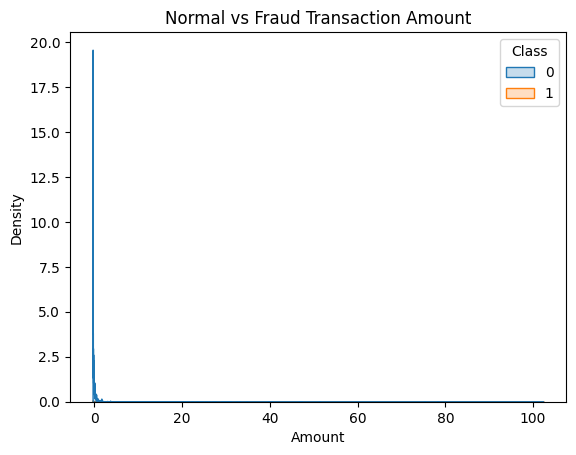

====================5.2 特征相关性分析


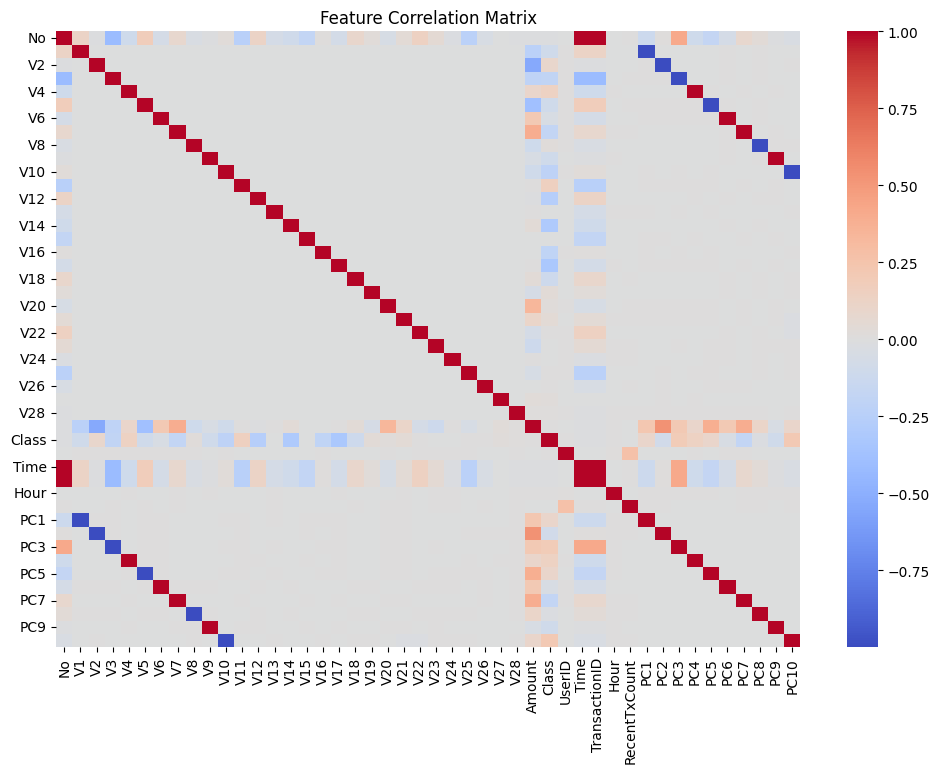

====================6. 扩展：合成数据生成（可选）


In [2]:
import pandas as pd

print("====================1. 数据获取与加载")
print("====================1.1 加载数据")
# 加载信用卡欺诈数据集（CSV格式）
data = pd.read_csv('/kaggle/input/abnormal-transaction-warning-system/creditcard.csv')
# 查看数据概况
print(data.head())
print(f"正常交易: {data['Class'].value_counts()[0]} 条")
print(f"异常交易: {data['Class'].value_counts()[1]} 条")

print("====================2. 数据探索与预处理")
print("====================2.1 处理不平衡数据")
from sklearn.utils import resample

# 分离多数类（正常）和少数类（异常）
df_majority = data[data['Class'] == 0]
df_minority = data[data['Class'] == 1]

# 上采样（过采样）少数类（可选方法：SMOTE）
#resample 数据重采样的工具函数，对数组或稀疏矩阵进行  上采样（过采样）​ 和 ​下采样（欠采样）
df_minority_upsampled = resample(df_minority,   #目标数组或稀疏矩阵
                                replace=True,     # 是否允许重复采样（上采样时需设为 True）
                                n_samples=len(df_majority),  # 目标样本数量（下采样时需小于原数据量，上采样时需大于原数据量）
                                random_state=42)  #随机种子（初始化一个伪随机数生成器），42：确保结果可复现
                                                 #stratify  按目标比例分层采样（适用于分类任务）

# 合并数据集
df_balanced = pd.concat([df_majority, df_minority_upsampled])

print("====================2.2 特征标准化")
from sklearn.preprocessing import StandardScaler

# 标准化金额特征（Amount）
scaler = StandardScaler()
data['Amount'] = scaler.fit_transform(data['Amount'].values.reshape(-1, 1))

# 删除无关列（如时间戳Time）
# data.drop(['Time'], axis=1, inplace=True)                                       #<<<<<<<<<<<<<<< 导致下一个命令错误

print("====================3. 特征工程")
print("====================3.1 基于领域知识的特征生成")
# 生成时间窗口特征（如小时段）
data['Hour'] = data['Time'] // 3600 % 24  # 假设Time单位为秒

# 生成交易频率特征（如用户近期交易次数）
# 假设数据中有UserID列（实际需根据数据集调整）
data['RecentTxCount'] = data.groupby('UserID')['TransactionID'].transform('count')

print("====================3.2 降维（可选）")
from sklearn.decomposition import PCA

# 对高维特征（如V1-V28）进行PCA降维
pca = PCA(n_components=10)
pca_features = pca.fit_transform(data[['V1', 'V2', 'V3','V4','V5','V6','V7','V8','V9','V10','V11','V12','V13','V14','V15','V16','V17','V18','V19','V20','V21','V22','V23','V24','V25','V26','V27', 'V28']])  

# 将降维结果合并到数据集
data_pca = pd.DataFrame(pca_features, columns=[f'PC{i}' for i in range(1, 11)])
data = pd.concat([data, data_pca], axis=1)

print("====================4. 构建最终数据集")
print("====================4.1 分割训练集与测试集")
from sklearn.model_selection import train_test_split

X = data.drop('Class', axis=1)
y = data['Class']

# 分层抽样保持类别比例
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("====================4.2 保存数据集")
# 保存为CSV或Pickle
X_train.to_csv('train_features.csv', index=False)
y_train.to_csv('train_labels.csv', index=False)
X_test.to_csv('test_features.csv', index=False)
y_test.to_csv('test_labels.csv', index=False)

print("====================5. 验证数据集质量")
print("====================5.1 可视化特征分布")
import seaborn as sns
import matplotlib.pyplot as plt

# 绘制正常与异常交易的金额分布对比
sns.histplot(data=data, x='Amount', hue='Class', element='step', stat='density')
plt.title('Normal vs Fraud Transaction Amount')
plt.show()
print("====================5.2 特征相关性分析")
# 计算特征相关性矩阵
corr_matrix = data.corr()

# 绘制热力图
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title('Feature Correlation Matrix')
plt.show()

print("====================6. 扩展：合成数据生成（可选）")
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_synth, y_synth = smote.fit_resample(X_train, y_train)

**Test**

In [3]:
import os

# 检查文件路径
file_path = "/kaggle/input/functions/FileObject.py"
if os.path.exists(file_path):
    print("文件存在！")
else:
    print("文件不存在，请检查数据集上传路径。")

文件存在！
